In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.imports import *
from lib.tools import *
from lib.ipyjobs import *
from lib.data import *
from lib.utils import *
from lib.modules import *
from lib.functions import *
from lib.normalizations import *
from ipynb.fs.defs.losses import *

In [3]:
G_list = load_G_list(data_path='data/rome', index_file='data_index.txt', cache='G_list', cache_prefix='cache/')

Load from 'cache/G_list.pickle'


In [4]:
data_list = generate_data_list(G_list, cache='data_list', cache_prefix='cache/', gviz_list=np.load('layouts/rome/gviz.npy', allow_pickle=True))

Load from 'cache/data_list.pickle'


In [55]:
minstress = RescaleByStress()
rescale = RescaleByDensity(return_scale=True)
rotate = RotateByPCA()
center = ZeroCenter()
normalize = Normalization()

In [56]:
batch = Batch.from_data_list(data_list[:1000])

(-11.470362186431885,
 9.949633121490479,
 -13.511882972717284,
 10.627096366882324)

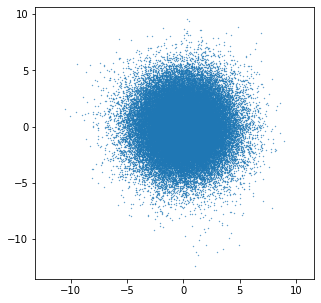

In [57]:
plt.figure(figsize=[5,5])
plt.scatter(batch.gt_pos.numpy()[:, 0], batch.gt_pos.numpy()[:, 1], s=0.1)
plt.axis('equal')

In [60]:
rotated = normalize(batch.gt_pos, batch)

(-31.175238132476807,
 31.817715167999268,
 -23.212651252746582,
 23.097527503967285)

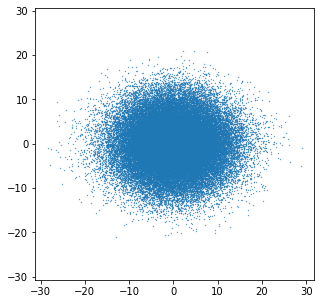

In [61]:
plt.figure(figsize=[5,5])
plt.scatter(rotated[:, 0], rotated[:, 1], s=0.1)
plt.axis('equal')

In [152]:
XXT = torch.einsum('ni,nj->nij', batch.pos, batch.pos)
cov = torch_scatter.scatter(XXT, batch.batch, dim=0, reduce='mean')
rotation = torch.linalg.eigh(cov).eigenvectors
rotated = torch.einsum('nij,nj->ni', rotation[batch.batch], batch.pos)

In [151]:
rotated

tensor([[-0.4184,  0.5845],
        [-0.2127,  0.5494],
        [ 0.1338,  1.1423],
        ...,
        [-0.1954, -0.9617],
        [-0.1957, -0.5070],
        [ 0.3816, -1.0026]])

In [94]:
torch.tensor([[1,2,3,4]]).view(-1,2,2)

tensor([[[1, 2],
         [3, 4]]])

In [12]:
executor = concurrent.futures.ProcessPoolExecutor(16)
gt_pos = list(tqdm(executor.map(get_ground_truth, data_list, G_list), total=len(G_list)))

  0%|          | 0/11531 [00:00<?, ?it/s]

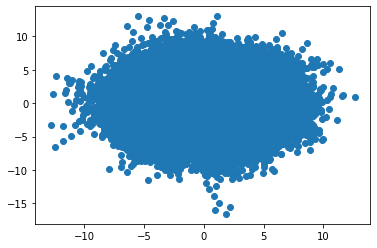

In [17]:
plt.scatter(np.concatenate(gt_pos)[:, 0], np.concatenate(gt_pos)[:, 1])

In [15]:
np.save('data/rome/gviz.npy', list(map(np.array, gt_pos)))

In [ ]:
for pos, G in zip(gt_pos, G_list):
    graph_vis(G, pos)
    plt.show()

In [16]:
np.load('pos_gviz.npy', allow_pickle=True)

array([array([[ 1.3649225 , -0.4669479 ],
              [-2.890938  , -1.1362636 ],
              [ 0.48577905, -1.7070543 ],
              [ 0.11412191,  0.39844608],
              [-0.14059353,  1.6989675 ],
              [ 2.5100317 , -0.56180656],
              [ 1.5260296 , -1.6569028 ],
              [ 1.9769897 ,  1.2516181 ],
              [ 0.8541026 ,  0.9471817 ],
              [-0.8996012 , -0.33236802],
              [-1.0108485 ,  0.52955365],
              [-1.1855662 ,  1.1331491 ],
              [-2.0170445 , -0.5247241 ],
              [-2.0730984 ,  0.64760613],
              [ 1.0852079 ,  0.34789205],
              [ 0.30050611, -0.56834805]], dtype=float32),
       array([[-0.77990866, -3.8170865 ],
              [-1.4557438 , -0.72777295],
              [ 0.09078789, -0.57624483],
              [ 1.9146814 ,  0.60098076],
              [-3.5704718 , -0.29693818],
              [ 1.0907907 , -0.90721774],
              [-1.0179648 ,  0.4836192 ],
              [ 0

In [4]:
criteria = {
    'stress': SemiNormalizedStressLoss(),
    'l1_angle': L1AngularLoss(),
    'edge': FixedMeanEdgeLengthVarianceLoss(),
    'ring': ExponentialRingLoss(),
    'tsne': TSNELoss()
}

In [4]:
def get_gt(pair, c):
    G, d = pair
    pos = get_ground_truth(d, G)
#     graph_vis(G, pos)
#     plt.show()
    return c(pos, Batch.from_data_list([d]))

In [19]:
gt_pos = []
for G, data in zip(tqdm(G_list), data_list):
    pos = get_ground_truth(data, G)
    gt_pos.append(pos)
#     graph_vis(G, pos, node_size=10)

  0%|          | 0/11531 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
index = slice(10000, 11000)
gt = {key: np.array(list(map(lambda pair: get_gt(pair, criteria[key]),
                             tqdm(zip(G_list[index], data_list[index]), 
                                  total=len(G_list[index]))))) 
      for key in criteria}

In [7]:
gt

{'stress': array([7.42245056e+02, 9.11455307e+01, 1.27554710e+02, 6.70366669e+01,
        2.63410004e+02, 8.59943787e+02, 6.32809265e+02, 1.18554184e+02,
        4.23355484e+00, 7.14990479e+02, 9.39811420e+00, 1.26208801e+01,
        2.38659706e+01, 8.58568573e+00, 6.41000549e+02, 7.86738342e+02,
        9.29583969e+01, 3.31658630e+02, 6.36310059e+02, 8.73393066e+02,
        6.62918823e+02, 7.13672791e+02, 5.97948608e+02, 1.04586755e+03,
        7.24887817e+02, 8.32883000e-01, 1.79875809e+02, 6.20436035e+02,
        4.79686554e+02, 7.68879333e+02, 8.80879700e+02, 9.13861008e+01,
        2.66045666e+00, 2.33754063e+00, 1.72110229e+02, 7.14458237e+01,
        8.40883255e+00, 9.80528259e+02, 1.86928055e+02, 2.73225594e+01,
        1.20027685e+01, 1.76474594e+02, 1.69846542e+02, 9.87745361e+01,
        3.81214104e+01, 7.52315918e+02, 4.84730072e+02, 1.37673553e+02,
        4.09505768e+02, 9.64181976e+01, 4.46202972e+02, 8.23216309e+02,
        1.17836876e+02, 1.74036789e+02, 9.23330612e+01

In [8]:
for c in gt:
    print(f'{c}: {gt[c].mean()}')

stress: 251.93093872070312
l1_angle: 80.31075286865234
edge: 0.08689337223768234
ring: 216.77174377441406
tsne: 0.18130950459062883


In [9]:
gt['index'] = np.arange(10000, 11000)

In [10]:
pd.DataFrame(gt).to_csv('gt.csv', index=None)

In [20]:
gt = []
for idx in tqdm(range(1277)):
    data, G = data_list[idx], G_list[idx]
    edge_attr = data.edge_attr
    pos_map = nx.nx_agraph.graphviz_layout(G, prog='neato')
    truth = np.array(list(pos_map.values()))

    start, end = get_full_edges(torch.tensor(truth), data)
    
    d = edge_attr[:, 0]
    w = 1/d**2

    u2 = ((start - end) ** 2).sum(dim=1)

    s = (w * d * u2.sqrt()).sum() / (w * u2).sum()

    loss_gt = criterion_scaled(torch.tensor(truth), data, s)
    gt.append([idx, loss_gt.item()])

pd.DataFrame(gt).to_csv("scaled_gt_loss_north.csv", index=False)

In [41]:
def get_performance_metrics(model, data, gt=None, criteria_list=[], **model_params):
    
    criteria = {'stress': SemiNormalizedStressLoss(),
                'l1_angle': RescaledL1AngularLoss(),
                'edge': RescaledEdgeLengthVarianceLoss(),
                'ring': ExponentialRingLoss()}
    
    def spc(x, gt):
        return (x - gt) / np.maximum(x, gt)
    
    def metric(criterion, pred):
        val = criteria[criterion](pred, data).item()
        val_spc = spc(val, gt[criterion])
        return val, val_spc
    
    with torch.no_grad():
        model.eval()
        data = preprocess_batch(model, data)
        
        if gt is None:
            raise NotImplementedError
        
        raw_pred = model(data, **model_params)
        scaled_pred = rescale_with_minimized_stress(raw_pred, data)
        
        stress, stress_spc = metric('stress', scaled_pred)
        angle, angle_spc = metric('l1_angle', scaled_pred)
        edge, edge_spc = metric('edge', scaled_pred)
        ring, ring_spc = metric('ring', scaled_pred)

        theta, degree, node = get_radians(scaled_pred, data, 
                                          return_node_degrees=True,
                                          return_node_indices=True)
        resolution_score = get_resolution_score(theta, degree, node)
        min_angle = get_min_angle(theta)
        
        other_criteria = CompositeLoss(criteria_list)
        _, losses = other_criteria(scaled_pred, data, return_components=True)
    
    return scaled_pred.cpu().numpy(), {
        'scaled_stress': stress,
        'scaled_stress_spc': stress_spc,
        'scaled_angle': angle,
        'scaled_angle_spc': angle_spc,
        'scaled_edge': edge,
        'scaled_edge_spc': edge_spc,
        'scaled_ring': ring,
        'scaled_ring_spc': ring_spc,
        'resolution_score': resolution_score.item(),
        'min_angle': min_angle.item(),
        'losses': list(map(torch.Tensor.item, losses))
    }

In [14]:
model = Model()

In [15]:
gt_data = pd.read_csv('gt.csv')

In [23]:
gt = gt_data[gt_data['index'] == 10000].iloc[0]

742.24506

In [42]:
get_performance_metrics(model, data_list[0], gt[gt['index'] == 10000].loc[0])

(array([[ 3.6564317, -7.483678 ],
        [ 6.4552016, -6.7766514],
        [ 4.975031 , -7.51798  ],
        [ 3.4743893, -7.6656427],
        [ 4.9427767, -7.53204  ],
        [ 6.000696 , -7.220092 ],
        [ 5.439663 , -7.1648912],
        [ 6.2270064, -7.10695  ],
        [ 4.0401945, -7.600282 ],
        [ 3.737557 , -7.7897916],
        [ 4.7858124, -7.6024394],
        [ 4.4266686, -7.5116525],
        [ 4.622263 , -7.3268585],
        [ 4.678761 , -7.1562705],
        [ 4.1232705, -7.6481957],
        [ 2.6307545, -7.6385036]], dtype=float32),
 {'scaled_stress': 98.8509292602539,
  'scaled_stress_spc': -0.86682170810237,
  'scaled_angle': 782.7119750976562,
  'scaled_angle_spc': -0.9251713184342703,
  'scaled_edge': 88.6295166015625,
  'scaled_edge_spc': -0.6488105076026917,
  'scaled_ring': 88.38970184326172,
  'scaled_ring_spc': -0.7441048618235078,
  'resolution_score': 0.21902045607566833,
  'min_angle': 1.2796244621276855,
  'losses': []})

In [56]:
def test(model, criteria_list, dataset, idx_range, callback=None, **model_params):
    if callback is None:
        callback = lambda *_, **__: None
    
    gt_data = pd.read_csv('gt.csv')
    
    metrics_all = {
        'scaled_stress': [],
        'scaled_stress_spc': [],
        'scaled_angle': [],
        'scaled_angle_spc': [],
        'scaled_edge': [],
        'scaled_edge_spc': [],
        'scaled_ring': [],
        'scaled_ring_spc': [],
        'resolution_score': [],
        'min_angle': [],
        'losses': []
    }
    
    for idx in tqdm(idx_range):
        gt = gt_data[gt_data['index'] == idx].iloc[0]
        pred, metrics = get_performance_metrics(model, dataset[idx],
                                                gt=gt, 
                                                criteria_list=criteria_list,
                                                **model_params)

        for m in metrics_all:
            metrics_all[m].append(metrics[m])

        callback(idx=idx, pred=pred, metrics=metrics)
        
    for m in metrics_all:
        metrics_all[m] = torch.tensor(metrics_all[m])
    
    return metrics_all

In [57]:
test(model, [], data_list, range(10000, 11000))

{'scaled_stress': tensor([3707.1021,  677.0781,  820.6936,  424.3945, 1512.3647, 3872.6873,
         3230.4604,  745.2945,   74.6983, 3192.2654,  116.7485,  167.8465,
          144.0673,   95.8986, 2994.1492, 3222.7610,  607.7095, 1680.6925,
         3167.7795, 3744.4153, 3680.6907, 3168.3462, 2982.0125, 4010.1575,
         3847.7197,   35.0921, 1034.4082, 2505.4893, 2394.8237, 3567.6458,
         3662.6248,  614.7994,   51.9152,   47.3314, 1335.4520,  590.5179,
           73.8589, 4199.8247, 1448.0000,  224.6272,  103.2588,  739.4623,
          990.1649,  798.3276,  250.9763, 3694.5466, 2398.2578, 1397.2581,
         2388.0251,  805.7881, 2627.8831, 3570.9390,  608.0754,  780.0820,
          741.6994,   56.5637, 2260.5781, 3051.6816, 1276.6079, 2614.0903,
         3828.2788, 3188.9736, 3035.3318,  307.8945, 3210.7776, 1316.1007,
          266.2831,  662.9781, 1338.9457,  567.3933,  634.1657, 1588.1663,
          482.7428,  160.2933, 3168.0464,  751.7986,  651.1307, 3412.1443,
        